In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from tqdm import tqdm

import os

from video_autoencoder import TinyVideoUNetAE, VideoUNetAutoencoder, ShallowVideoUNetAutoencoder, VideoUNetAutoencoderNoSkips, ShallowVideoAutoencoderNoSkips
from customDataset import CustomKineticsDataset, CustomKineticsDataset_UNet

In [2]:
model = VideoUNetAutoencoderNoSkips(base_channels=32, latent_dim=8,p=0)

'''
Joao_4_fail - joint Torque
Joao_2_fail - Collision
10_Gui_Fail - Extra person
Gui_Fail_3 - Person Disappears
1_p2_fail - drop cup
3_p2_fail - robot human handover
'''

'\nJoao_4_fail - joint Torque\nJoao_2_fail - Collision\n10_Gui_Fail - Extra person\nGui_Fail_3 - Person Disappears\n1_p2_fail - drop cup\n3_p2_fail - robot human handover\n'

In [3]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = CustomKineticsDataset_UNet(root_dir='Labelled Dataset',
                                frames_per_clip=32,
                                transform=transform)

train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

{'Human Handover': 0, 'Idle': 1, 'Move No Cup': 2, 'Move with Cup': 3, 'Place': 4, 'Robot Handover': 5, 'Robot Picking Object': 6}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train_autoencoder(model, train_loader, val_loader, num_epochs=20, lr=1e-3, device="cuda"):
    model = model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.3)

    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #    optimizer, mode="min", factor=0.1, patience=5, verbose=True
    #)

    best_val_loss = float("inf")
    all_train_losses = []
    all_val_losses = []

    for epoch in range(num_epochs):
        # -------- TRAIN --------
        model.train()
        train_loss = 0.0
        for clips, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):

            clips = clips.to(device)  # (B, C, T, H, W)

            optimizer.zero_grad()
            recon = model(clips)

            loss = criterion(recon, clips)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * clips.size(0)

        train_loss /= len(train_loader.dataset)
        all_train_losses.append(train_loss)

        # -------- VALIDATION --------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for clips, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):

                clips = clips.to(device)
                recon = model(clips)


                loss = criterion(recon, clips)
                val_loss += loss.item() * clips.size(0)

        val_loss /= len(val_loader.dataset)
        all_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return all_train_losses, all_val_losses



In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
all_train_losses, all_val_losses = train_autoencoder(model, train_loader, val_loader, num_epochs=40, lr=1e-6, device=device)

Epoch 1/40 [Val]: 100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Epoch 1/40 | Train Loss: 0.170239 | Val Loss: 0.155579


Epoch 2/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 2/40 | Train Loss: 0.139148 | Val Loss: 0.128805


Epoch 3/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 3/40 | Train Loss: 0.114540 | Val Loss: 0.106102


Epoch 4/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 4/40 | Train Loss: 0.096673 | Val Loss: 0.090428


Epoch 5/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 5/40 | Train Loss: 0.084025 | Val Loss: 0.079936


Epoch 6/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 6/40 | Train Loss: 0.075122 | Val Loss: 0.071579


Epoch 7/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 7/40 | Train Loss: 0.068588 | Val Loss: 0.066110


Epoch 8/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 8/40 | Train Loss: 0.063803 | Val Loss: 0.062076


Epoch 9/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 9/40 | Train Loss: 0.060215 | Val Loss: 0.058557


Epoch 10/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 10/40 | Train Loss: 0.057476 | Val Loss: 0.055988


Epoch 11/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 11/40 | Train Loss: 0.055220 | Val Loss: 0.053953


Epoch 12/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 12/40 | Train Loss: 0.053480 | Val Loss: 0.052255


Epoch 13/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 13/40 | Train Loss: 0.051884 | Val Loss: 0.050823


Epoch 14/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 14/40 | Train Loss: 0.050610 | Val Loss: 0.049628


Epoch 15/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 15/40 | Train Loss: 0.049513 | Val Loss: 0.048511


Epoch 16/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 16/40 | Train Loss: 0.048544 | Val Loss: 0.047654


Epoch 17/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 17/40 | Train Loss: 0.047630 | Val Loss: 0.046748


Epoch 18/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 18/40 | Train Loss: 0.046882 | Val Loss: 0.046089


Epoch 19/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 19/40 | Train Loss: 0.046164 | Val Loss: 0.045316


Epoch 20/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 20/40 | Train Loss: 0.045559 | Val Loss: 0.044837


Epoch 21/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 21/40 | Train Loss: 0.044994 | Val Loss: 0.044179


Epoch 22/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 22/40 | Train Loss: 0.044415 | Val Loss: 0.043656


Epoch 23/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 23/40 | Train Loss: 0.043964 | Val Loss: 0.043328


Epoch 24/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 24/40 | Train Loss: 0.043420 | Val Loss: 0.042692


Epoch 25/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 25/40 | Train Loss: 0.043004 | Val Loss: 0.042308


Epoch 26/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 26/40 | Train Loss: 0.042566 | Val Loss: 0.042005


Epoch 27/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 27/40 | Train Loss: 0.042228 | Val Loss: 0.041498


Epoch 28/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 28/40 | Train Loss: 0.041851 | Val Loss: 0.041202


Epoch 29/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 29/40 | Train Loss: 0.041569 | Val Loss: 0.040804


Epoch 30/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 30/40 | Train Loss: 0.041158 | Val Loss: 0.040633


Epoch 31/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 31/40 | Train Loss: 0.040827 | Val Loss: 0.040149


Epoch 32/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 32/40 | Train Loss: 0.040616 | Val Loss: 0.039877


Epoch 33/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 33/40 | Train Loss: 0.040255 | Val Loss: 0.039634


Epoch 34/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 34/40 | Train Loss: 0.040063 | Val Loss: 0.039326


Epoch 35/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 35/40 | Train Loss: 0.039754 | Val Loss: 0.039168


Epoch 36/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 36/40 | Train Loss: 0.039526 | Val Loss: 0.038808


Epoch 37/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 37/40 | Train Loss: 0.039276 | Val Loss: 0.038590


Epoch 38/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 38/40 | Train Loss: 0.039014 | Val Loss: 0.038348


Epoch 39/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 39/40 | Train Loss: 0.038754 | Val Loss: 0.038189


Epoch 40/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]

Epoch 40/40 | Train Loss: 0.038592 | Val Loss: 0.037922


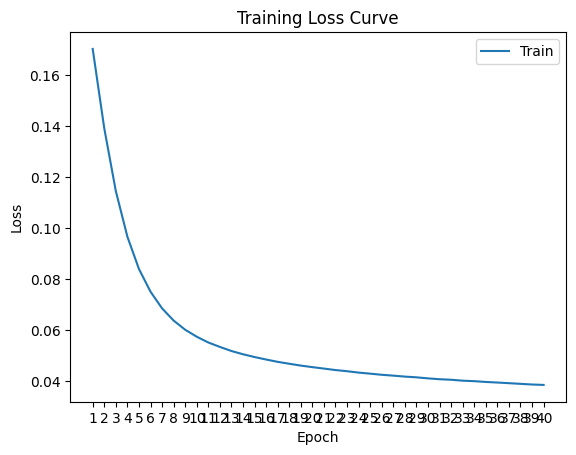

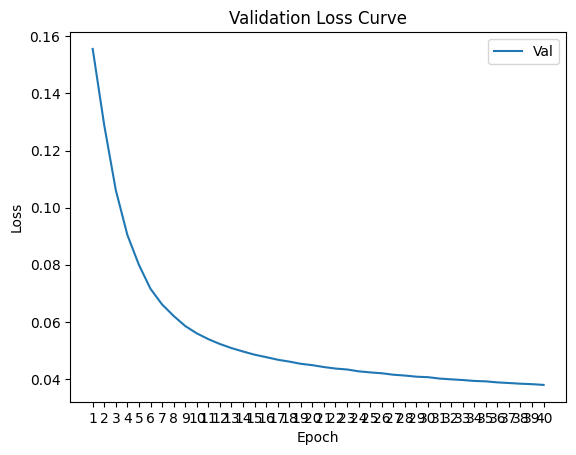

In [6]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.xticks(range(1, len(all_train_losses) + 1))  # Show all epoch numbers on x-axis
plt.show()

# Plot validation loss
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss Curve")
plt.xticks(range(1, len(all_val_losses) + 1))  # Show all epoch numbers on x-axis
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def denormalize(tensor):
    """
    Undo normalization: from [-1,1] back to [0,1] for visualization.
    Assumes you used mean=0.5, std=0.5 normalization.
    """
    return tensor * 0.5 + 0.5
'''
def show_clip(original, recon, max_frames=8):
    """
    Display first `max_frames` frames from original and reconstruction.
    original, recon: tensors (C, T, H, W) in [-1,1]
    """
    original = denormalize(original).cpu().numpy()
    recon = denormalize(recon).cpu().detach().numpy()

    # (C,T,H,W) -> (T,H,W,C)
    original = np.transpose(original, (1, 2, 3, 0))
    recon = np.transpose(recon, (1, 2, 3, 0))

    num_frames = min(max_frames, original.shape[0])

    fig, axes = plt.subplots(2, num_frames, figsize=(3*num_frames, 6))
    for i in range(num_frames):
        axes[0, i].imshow(original[i])
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Orig {i}")

        axes[1, i].imshow(recon[i])
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Recon {i}")

    plt.show()
'''

def show_clip(original, recon, max_frames=8):
    """
    Display first `max_frames` frames from original and reconstruction.
    original, recon: tensors (C, T, H, W) in [-1,1]
    """
    #original = denormalize(original).cpu().numpy()
    #recon = denormalize(recon).cpu().detach().numpy()

    # (C,T,H,W) -> (T,H,W,C) if C>1, else (T,H,W)
    if original.shape[0] == 1:
        original = np.transpose(original, (1, 2, 0))[:, :, 0]  # squeeze channel
        recon = np.transpose(recon, (1, 2, 0))[:, :, 0]
    else:
        original = np.transpose(original, (1, 2, 3, 0))
        recon = np.transpose(recon, (1, 2, 3, 0))

    num_frames = min(max_frames, original.shape[0])

    fig, axes = plt.subplots(2, num_frames, figsize=(3*num_frames, 6))
    for i in range(num_frames):
        axes[0, i].imshow(original[i], cmap='gray' if original.ndim==2 else None)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Orig {i}")

        axes[1, i].imshow(recon[i], cmap='gray' if recon.ndim==2 else None)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Recon {i}")

    plt.show()

def plot_video_clips(clips, n_clips=4, n_frames=8):
    """
    Plot a few clips from a batch of video tensors.

    Args:
        clips (Tensor): Batch of clips, shape (B, C, T, H, W).
        n_clips (int): How many clips from the batch to plot.
        n_frames (int): How many frames per clip to show.
    """
    B, C, T, H, W = clips.shape
    n_clips = min(n_clips, B)
    n_frames = min(n_frames, T)

    fig, axes = plt.subplots(n_clips, n_frames, figsize=(n_frames*2, n_clips*2))

    # Handle case where only 1 clip is plotted
    if n_clips == 1:
        axes = [axes]

    for i in range(n_clips):
        # Evenly sample frames
        frame_indices = torch.linspace(0, T-1, steps=n_frames).long()
        for j, t in enumerate(frame_indices):
            frame = clips[i, :, t, :, :]  # (C, H, W)
            frame = torchvision.transforms.functional.to_pil_image(frame)

            axes[i][j].imshow(frame, cmap="gray" if frame.mode=="L" else None)
            axes[i][j].axis("off")

    plt.tight_layout()
    plt.show()


def plot_reconstructions(original, recon, n_clips=2, n_frames=8):
    """
    Plot original vs reconstructed video clips.

    Args:
        original (Tensor): Batch of original clips, shape (B, C, T, H, W).
        recon (Tensor): Batch of reconstructed clips, same shape.
        n_clips (int): Number of clips to show.
        n_frames (int): Number of frames per clip to show.
    """
    B, C, T, H, W = original.shape
    n_clips = min(n_clips, B)
    n_frames = min(n_frames, T)

    fig, axes = plt.subplots(n_clips*2, n_frames, figsize=(n_frames*2, n_clips*4))

    # Handle case where only 1 clip is plotted
    if n_clips == 1:
        axes = [axes]

    for i in range(n_clips):
        frame_indices = torch.linspace(0, T-1, steps=n_frames).long()

        for j, t in enumerate(frame_indices):
            # --- Original ---
            orig_frame = torchvision.transforms.functional.to_pil_image(original[i, :, t, :, :].cpu().clamp(0,1))
            axes[i*2][j].imshow(orig_frame, cmap="gray" if orig_frame.mode=="L" else None)
            axes[i*2][j].axis("off")
            if j == 0:
                axes[i*2][j].set_ylabel("Original", fontsize=12)

            # --- Reconstruction ---
            recon_frame = torchvision.transforms.functional.to_pil_image(recon[i, :, t, :, :].cpu().clamp(0,1))
            axes[i*2+1][j].imshow(recon_frame, cmap="gray" if recon_frame.mode=="L" else None)
            axes[i*2+1][j].axis("off")
            if j == 0:
                axes[i*2+1][j].set_ylabel("Reconstruction", fontsize=12)

    plt.tight_layout()
    plt.show()

In [8]:
#device = "cuda" if torch.cuda.is_available() else "cpu"

#model.load_state_dict(torch.load("best_autoencoder.pth"))

#model.eval()
#model.to(device)


In [9]:
model.eval()
reconstruction_errors = []

with torch.no_grad():
    for clips, _ in tqdm(val_loader, desc="Computing reconstruction errors"):
        
        # Prepare inputs
        #feature_vector = feature_vector.squeeze(dim=1).cuda()

        # Forward pass
        clips = clips.to(device, dtype=torch.float32)
        output = model(clips)
        
        # Compute L1 reconstruction error per sample using your existing criterion
        # criterion gives a scalar loss if inputs are batched — so compute per sample manually
        errors = torch.mean(torch.abs(clips - output), dim=[1,2,3,4])  # L1 per sample

        reconstruction_errors.extend(errors.cpu().numpy())

# Convert to numpy
reconstruction_errors = np.array(reconstruction_errors)

Computing reconstruction errors: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


✅ 95th percentile threshold: 0.043391


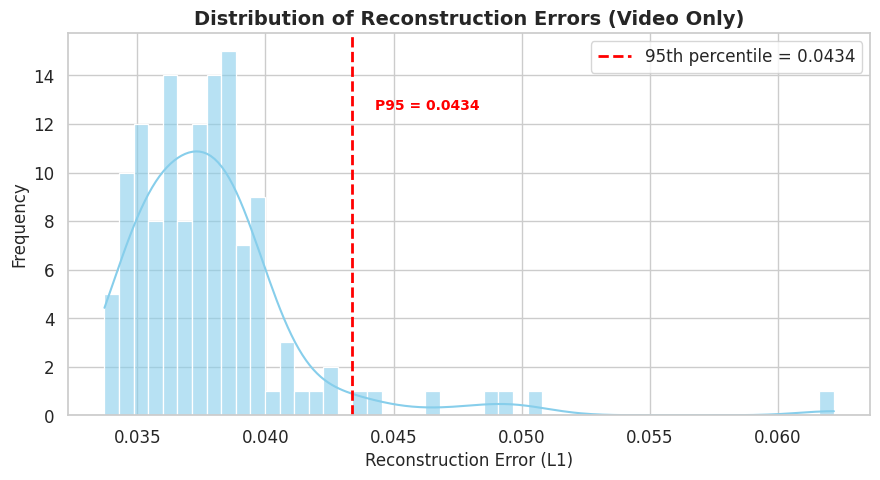

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Compute threshold based on 95th percentile only ---
threshold_95 = np.percentile(reconstruction_errors, 95)

print(f"✅ 95th percentile threshold: {threshold_95:.6f}")

# --- Plot ---
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(9, 5))

sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue', alpha=0.6)

# Draw line for the 95th percentile
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=2, label=f'95th percentile = {threshold_95:.4f}')

# Annotate
plt.text(threshold_95 * 1.02, plt.ylim()[1] * 0.8,
         f"P95 = {threshold_95:.4f}",
         color='red', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel("Reconstruction Error (L1)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Reconstruction Errors (Video Only)", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()